In [320]:
import graphlab as gl
import graphlab.aggregate as agg
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import matplotlib.dates as md
import time

%matplotlib inline

In [2]:
def readData(city, month, day):
    if month == 'dec':
        monthnum = '12'
    else:
        monthnum = '11'
    
    if city == 'milano':
        shortcity = 'mi'
    else:
        shortcity = 'tn'
    names = ['squareId', 'interval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internetActivity']
    data = pd.read_csv('./' + city+'_telecom_' + month + '/sms-call-internet-' + shortcity + '-2013-' + monthnum + '-' + day + '.txt', delimiter='\t', names=names).fillna(0)

    return gl.SFrame(data)


In [126]:
milanoData = []

for i in range(1, 30):
    if i < 10:
        milanoData.append(readData('milano', 'dec', '0' + str(i)))
    else:
        milanoData.append(readData('milano', 'dec', str(i)))
        

In [301]:
trentoData = []

for i in range(1, 30):
    if i < 10:
        trentoData.append(readData('trento', 'dec', '0' + str(i)))
    else:
        trentoData.append(readData('trento', 'dec', str(i)))
        

In [876]:
def getAggregateData(data):
    aggregates = data.groupby(key_columns='interval', operations = {
                                            'smsIn': agg.SUM('smsIn'),
                                            'distinct': agg.COUNT(),
                                            'smsOut': agg.SUM('smsOut'),
                                            'callIn': agg.SUM('callIn'),
                                            'callOut': agg.SUM('callOut'),
                                            'internetActivity': agg.SUM('internetActivity'),
    })
    return aggregates.sort('interval')
    
def plotAggregateByHour(aggregates, totals):
    minimum = min(aggregates.select_column('interval'))
    plt.scatter([(((i - minimum) / 1000.0) / 3600.0) for i in aggregates.select_column('interval')], totals)

    plt.show()
    
def calculateNormalizedValues(aggregates, only='All'):
    df = aggregates.to_dataframe()
    if True:
        means = {
            'callIn': 1,
            'smsOut': 1,
            'smsIn': 1,
            'callIn': 1,
            'callOut': 1,
            'internetActivity': 1,
        }
    else:
       means = df.mean()

    if only == 'Internet':
        return [i['internetActivity'] / means['internetActivity'] for i in aggregates]
    if only == 'Mobile':
        return [i['callIn'] / means['callIn'] + i['smsOut'] / means['smsOut'] + i['smsIn'] / means['smsIn'] + i['callOut'] / means['callOut'] for i in aggregates]
    else:
        return [i['callIn'] / means['callIn'] + i['internetActivity'] / means['internetActivity']  + i['smsOut'] / means['smsOut'] + i['smsIn'] / means['smsIn'] + i['callOut'] / means['callOut'] for i in aggregates]

def findMostCongestedPeriod(data):
    # Give 1 to 5 points to the 5 most popular intervals
    periods = [0] * 144
    a = 0
    for i in data:
        a = a + 1
        agg = getAggregateData(i)
        norm = calculateNormalizedValues(agg)
        
        busiest = sorted(range(len(norm)), key=lambda i: norm[i])[-5:]
        for j in range(1, 6):
            periods[busiest[j - 1]] = periods[busiest[j - 1]] + j
        
    return periods

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def chunk(l, n, mean):
    chunked = chunks(l, n)
    if mean:
        return [sum(i) / 3.0 for i in chunked]
        
    return [sum(i) for i in chunked]

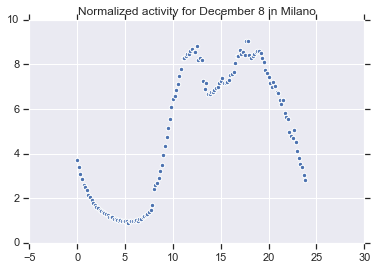

107


In [849]:
aggregates = getAggregateData(milanoData[7])
norm = calculateNormalizedValues(aggregates)
plt.title('Normalized activity for December 8 in Milano')
plotAggregateByHour(aggregates, calculateNormalizedValues(aggregates))
maxIndex = norm.index(max(norm))
print(norm.index(max(norm)))

In [850]:
ratings = findMostCongestedPeriod(milanoData)
ratingsTrento = findMostCongestedPeriod(trentoData)

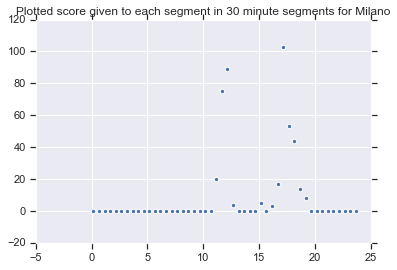

In [851]:
minimum = min(aggregates.select_column('interval'))
time = [(((i - minimum) / 1000.0) / 3600.0) for i in aggregates.select_column('interval')]
plt.scatter(chunk(time, 3, True), list(chunk(ratings, 3, False)))
plt.title('Plotted score given to each segment in 30 minute segments for Milano')
plt.show()

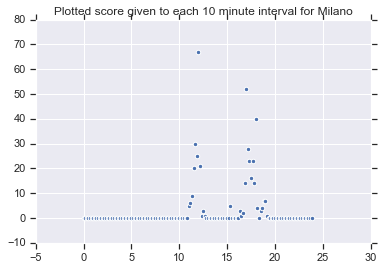

In [852]:
plt.scatter(time, ratings)
plt.title('Plotted score given to each 10 minute interval for Milano')
plt.show()

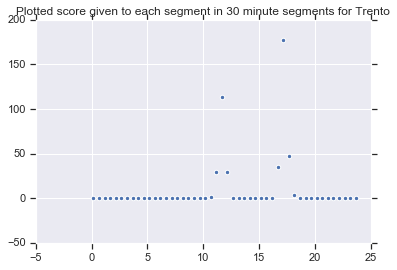

In [856]:
minimum = min(aggregates.select_column('interval'))
time = [(((i - minimum) / 1000.0) / 3600.0) for i in aggregates.select_column('interval')]
plt.scatter(chunk(time, 3, True), list(chunk(ratingsTrento, 3, False)))
plt.title('Plotted score given to each segment in 30 minute segments for Trento')
plt.show()

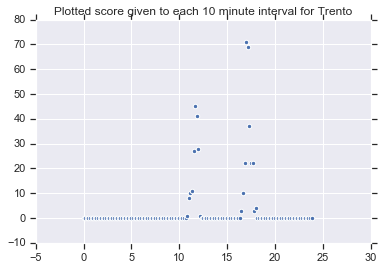

In [857]:
plt.scatter(time, ratingsTrento)
plt.title('Plotted score given to each 10 minute interval for Trento')
plt.show()

In [858]:
def readProvinceData(day, city):
    names = ['squareId', 'province', 'timeInterval', 'sqToProvince', 'provToSquare']
    
    short = 'tn'
    if city == 'milano':
        short = 'mi'
    
    if day < 10:
        day = '0' + str(day)
    else:
        day = str(day)
    
    city = 'trento_provinces_dec'
    if city == 'milano':
        city = 'milano_provinces_telecom'
    
    data = pd.read_csv('./' + city + '/' + short + '-to-provinces-2013-12-' + str(day) + '.txt', delimiter='\t', names=names).fillna(0)

    return gl.SFrame(data)

In [342]:
milanoProvData = []

for i in range(1, 30):
    milanoProvData.append(readProvinceData(i, 'milano'))
        

In [379]:
trentoProvData = []

for i in range(1, 30):
    trentoProvData.append(readProvinceData(i, 'trento'))

In [859]:
def countProvinceFrequencies(data):
    return data.groupby(key_columns='province', operations= {
        'count': agg.COUNT()
    })


In [367]:
def getAllCounts(data):
    allFreqs = {}
    for i in data:
        freqs = countProvinceFrequencies(i)
        
        for i in freqs:
            allFreqs[i['province']] = i['count'] + allFreqs.get(i['province'], 0)
            
    return allFreqs


In [530]:
def plotProvinceData(data):
    provinces = data.keys()
    freqs = data.values()
    topprov = []
    topfreqs = []
    
    top = sorted(range(len(freqs)), key=lambda i: freqs[i])[-5:]
    for j in top:
        topprov.append(provinces[j])
        topfreqs.append(freqs[j])
        
    pos = np.arange(len(topprov))
    ax = plt.axes()
    width = 0.7
    ax.set_xticks(pos + width / 2)
    ax.set_xticklabels(topprov)

    plt.bar(pos,topfreqs , width, color='r')
    plt.show()
    


In [860]:
milanoProvs = getAllCounts(milanoProvData)

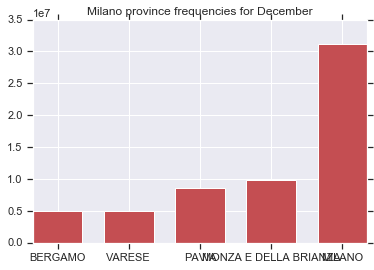

In [861]:
plt.title('Milano province frequencies for December')
plotProvinceData(milanoProvs)

In [862]:
trentoProvs = getAllCounts(trentoProvData)

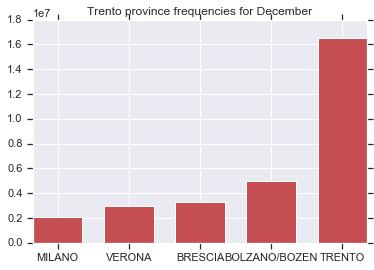

In [863]:
plt.title('Trento province frequencies for December')
plotProvinceData(trentoProvs)

In [864]:
names = ['user', 'language', 'municipality', 'things', 'more', 'thingers']
milanoSocial = gl.SFrame(pd.read_csv('./social_pulse_milano.csv', delimiter='\t', names=names).fillna(0))


In [865]:
milanoSocial.head(3)

user,language,municipality,things,more,thingers
485cbddfba,it,Milano,1383259533,45.4955508,9.21973911
ad4c19f95f,en,Milano,1383259651,45.46845905,9.13473716
806e3d0109,it,Milano,1383259691,45.48169016,9.17273641


In [866]:
langs = milanoSocial.groupby(key_columns='user', operations= {
        'languages': agg.DISTINCT('language')
    })

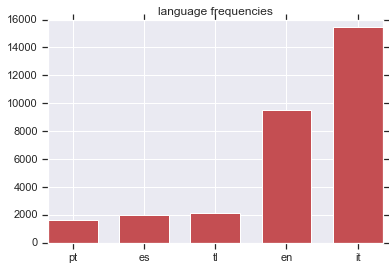

In [867]:
frequencies = {}
for i in langs:
    languageList = i['languages']
    for l in languageList:
        frequencies[l] = frequencies.get(l, 0) + 1
plt.title('language frequencies')
plotProvinceData(frequencies)

In [868]:
print('There were in total ' + str(frequencies['fi']) + ' tweeters who wrote in Finnish.')

There were in total 699 tweeters who wrote in Finnish.


In [869]:
novDays = [26, 27, 28]
decDays = [24, 25, 26]

novData = []
decData = []

for i in novDays:
    novData.append(readData('milano', 'nov', str(i)))
    
for i in decDays:
    decData.append(readData('milano', 'dec', str(i)))
        

In [442]:
allDec = gl.SFrame(decData[1].to_dataframe().append(decData[2].to_dataframe()).append(decData[0].to_dataframe()))
allNov = gl.SFrame(novData[1].to_dataframe().append(novData[2].to_dataframe()).append(novData[0].to_dataframe()))

0

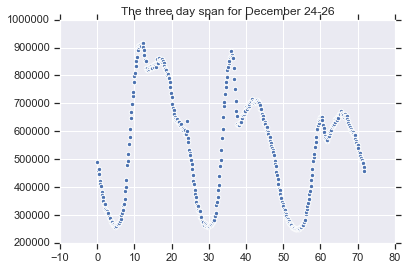

In [877]:
aggregates = getAggregateData(allDec)
norm = calculateNormalizedValues(aggregates, '')
plt.title('The three day span for December 24-26')
plotAggregateByHour(aggregates, norm)
plt.show()

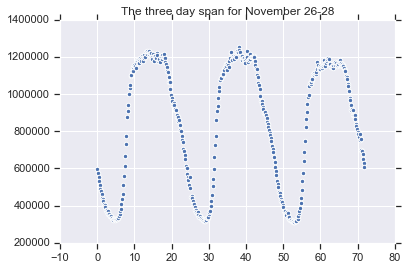

In [878]:
aggregates = getAggregateData(allNov)
norm = calculateNormalizedValues(aggregates, '')
plt.title('The three day span for November 26-28')
plotAggregateByHour(aggregates, norm)
plt.show()

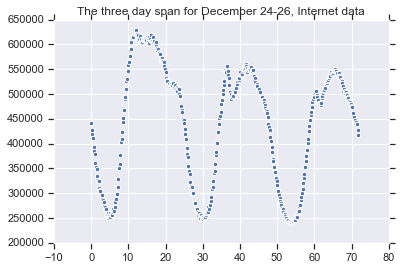

In [879]:
aggregates = getAggregateData(allDec)
norm = calculateNormalizedValues(aggregates, 'Internet')
plt.title('The three day span for December 24-26, Internet data')
plotAggregateByHour(aggregates, norm)
plt.show()

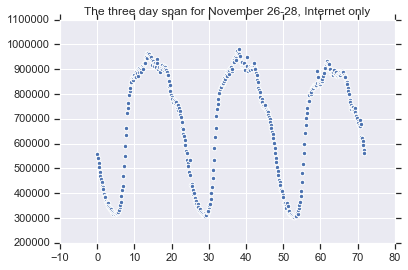

In [880]:
aggregates = getAggregateData(allNov)
norm = calculateNormalizedValues(aggregates, 'Internet')
plt.title('The three day span for November 26-28, Internet only')
plotAggregateByHour(aggregates, norm)
plt.show()

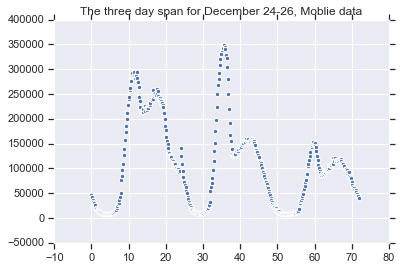

In [881]:
aggregates = getAggregateData(allDec)
norm = calculateNormalizedValues(aggregates, 'Mobile')
plt.title('The three day span for December 24-26, Moblie data')
plotAggregateByHour(aggregates, norm)
plt.show()

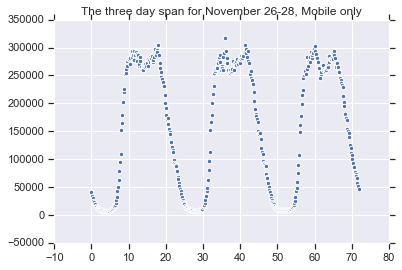

In [882]:
aggregates = getAggregateData(allNov)
norm = calculateNormalizedValues(aggregates, 'Mobile')
plt.title('The three day span for November 26-28, Mobile only')
plotAggregateByHour(aggregates, norm)
plt.show()

In [501]:
names=['stationId', 'date', 'value']

milanoRainStation = gl.SFrame(pd.read_csv('./Milano_WeatherPhenomena/mi_meteo_2006.csv', names=names).fillna(0))

In [531]:
values = []
for i in range(0, 25):
    if i < 10:
        values.append('2013/11/15 0' + str(i) + ':00')
        values.append('2013/11/14 0' + str(i) + ':00')
    else:
        values.append('2013/11/15 ' + str(i) + ':00')
        values.append('2013/11/14 ' + str(i) + ':00')

rains = {}
r = milanoRainStation.filter_by(values, 'date').sort('date')
for i in r:
    rains[i['date']] = i['value']


In [508]:
rainydays = [15, 30]
notRainy = [13, 14]

rainyData = []
notRainyData = []

for i in rainydays:
    rainyData.append(readData('milano', 'nov', str(i)))
    
for i in notRainy:
    notRainyData.append(readData('milano', 'dec', str(i)))
        
allRainy = gl.SFrame(rainyData[1].to_dataframe().append(rainyData[0].to_dataframe()))
allNotRainy = gl.SFrame(notRainyData[1].to_dataframe().append(notRainyData[0].to_dataframe()))

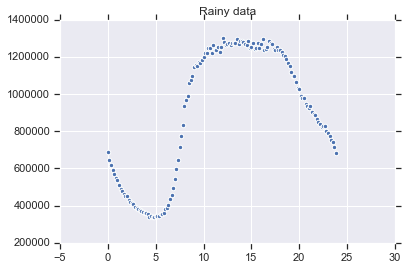

In [883]:
aggregates = getAggregateData(rainyData[0])
norm = calculateNormalizedValues(aggregates, '')
plt.title('Rainy data')
plotAggregateByHour(aggregates, norm)
plt.show()

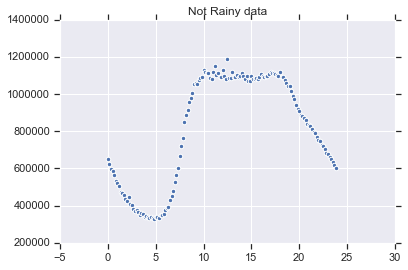

In [884]:
aggregates = getAggregateData(notRainyData[0])
norm = calculateNormalizedValues(aggregates, '')
plt.title('Not Rainy data')
plotAggregateByHour(aggregates, norm)
plt.show()

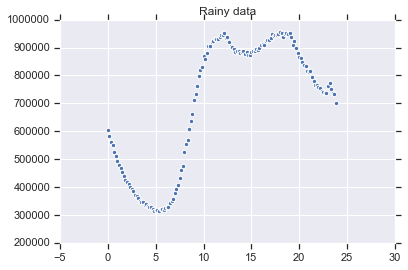

In [885]:
aggregates = getAggregateData(rainyData[1])
norm = calculateNormalizedValues(aggregates, '')
plt.title('Rainy data')
plotAggregateByHour(aggregates, norm)
plt.show()

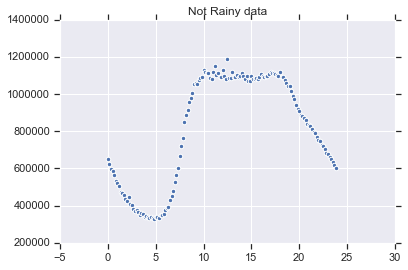

In [886]:
aggregates = getAggregateData(notRainyData[0])
norm = calculateNormalizedValues(aggregates, '')
plt.title('Not Rainy data')
plotAggregateByHour(aggregates, norm)
plt.show()

In [552]:
heatmapData = notRainyData[0]

groupedMap = heatmapData.groupby(key_columns=['squareId', 'interval'],operations = {
                                            'smsIn': agg.SUM('smsIn'),
                                            'smsOut': agg.SUM('smsOut'),
                                            'callIn': agg.SUM('callIn'),
                                            'callOut': agg.SUM('callOut'),
                                            'internetActivity': agg.SUM('internetActivity'),
    })

In [629]:
midpoint = groupedMap.groupby(key_columns='interval', operations ={
    'min': agg.MIN('interval')
}).sort('interval')[0]['interval'] / 1000 + 3600 * 14

times = np.array(groupedMap.groupby(key_columns='interval', operations ={
    'min': agg.MIN('interval')
}).select_column('interval'))

In [636]:
dayItems = []
nightItems = []

for i in groupedMap:
    if i['interval']/ 1000 > midpoint + 3600 * 6 or i['interval']/ 1000 < midpoint - 3600 * 6:
        nightItems.append(i)
    else:
        dayItems.append(i)

In [640]:
dayItems = gl.SFrame(pd.DataFrame(dayItems))
nightItems = gl.SFrame(pd.DataFrame(nightItems))

In [710]:
dayActivity = dayItems.groupby(key_columns='squareId', operations = {
                                            'smsIn': agg.SUM('smsIn'),
                                            'smsOut': agg.SUM('smsOut'),
                                            'callIn': agg.SUM('callIn'),
                                            'callOut': agg.SUM('callOut'),
                                            'internetActivity': agg.SUM('internetActivity'),
}).sort('squareId')

nightActivity = nightItems.groupby(key_columns='squareId', operations = {
                                            'smsIn': agg.SUM('smsIn'),
                                            'smsOut': agg.SUM('smsOut'),
                                            'callIn': agg.SUM('callIn'),
                                            'callOut': agg.SUM('callOut'),
                                            'internetActivity': agg.SUM('internetActivity'),
}).sort('squareId')
nightActivity = nightActivity.append(gl.SFrame(pd.DataFrame([{'squareId': 5239, 'smsIn': 0.0, 'smsOut': 0.0, 'callIn': 0.0, 'callOut': 0.0, 'internetActivity': 0.0}, {'squareId': 5339, 'smsIn': 0.0, 'smsOut': 0.0, 'callIn': 0.0, 'callOut': 0.0, 'internetActivity': 0.0}])))
dayActivity = dayActivity.append(gl.SFrame(pd.DataFrame([{'squareId': 5239, 'smsIn': 0.0, 'smsOut': 0.0, 'callIn': 0.0, 'callOut': 0.0, 'internetActivity': 0.0}, {'squareId': 5339, 'smsIn': 0.0, 'smsOut': 0.0, 'callIn': 0.0, 'callOut': 0.0, 'internetActivity': 0.0}])))
nightActivity = nightActivity.sort('squareId')
dayActivity = dayActivity.sort('squareId')

In [739]:
print(nightActivity.head(3))
print(dayActivity.head(3))

+----------+---------------+---------------+------------------+---------------+
| squareId |    callOut    |     smsOut    | internetActivity |     callIn    |
+----------+---------------+---------------+------------------+---------------+
|    1     | 12.2510897519 | 16.6159487361 |  629.089270129   | 8.71806941255 |
|    2     | 12.4302252856 |  16.754108693 |  630.262433723   | 8.83165803541 |
|    3     | 12.6209079747 | 16.9011745014 |   631.51121996   |  8.9525686309 |
+----------+---------------+---------------+------------------+---------------+
+---------------+
|     smsIn     |
+---------------+
| 25.5421888204 |
| 25.8121181854 |
| 26.0994473162 |
+---------------+
[3 rows x 6 columns]

+----------+---------------+---------------+------------------+---------------+
| squareId |    callOut    |     smsOut    | internetActivity |     callIn    |
+----------+---------------+---------------+------------------+---------------+
|    1     | 69.5173489103 | 31.9711208149 |  765.62

In [836]:
dayImg = np.fliplr(np.array(calculateNormalizedValues(dayActivity))[::-1].reshape((100, 100)))
nightImg = np.fliplr(np.array(calculateNormalizedValues(nightActivity))[::-1].reshape((100, 100)))

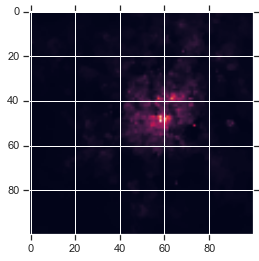

In [839]:
plt.imshow(dayImg)
plt.show()

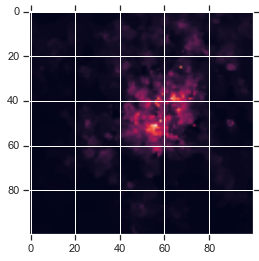

In [746]:
plt.imshow(nightImg)
plt.show()

In [843]:
def heatMapData(data, shape, maxId):
    groupedMap = heatmapData.groupby(key_columns=['squareId', 'interval'],operations = {
                                                'smsIn': agg.SUM('smsIn'),
                                                'smsOut': agg.SUM('smsOut'),
                                                'callIn': agg.SUM('callIn'),
                                                'callOut': agg.SUM('callOut'),
                                                'internetActivity': agg.SUM('internetActivity'),
        })
    midpoint = groupedMap.groupby(key_columns='interval', operations ={
        'min': agg.MIN('interval')
    }).sort('interval')[0]['interval'] / 1000 + 3600 * 14
    
    dayItems = []
    nightItems = []

    for i in groupedMap:
        if i['interval']/ 1000 > midpoint + 3600 * 6 or i['interval']/ 1000 < midpoint - 3600 * 6:
            nightItems.append(i)
        else:
            dayItems.append(i)
            
    dayItems = gl.SFrame(pd.DataFrame(dayItems))
    nightItems = gl.SFrame(pd.DataFrame(nightItems))
    
    dayActivity = dayItems.groupby(key_columns='squareId', operations = {
                                                'smsIn': agg.SUM('smsIn'),
                                                'smsOut': agg.SUM('smsOut'),
                                                'callIn': agg.SUM('callIn'),
                                                'callOut': agg.SUM('callOut'),
                                                'internetActivity': agg.SUM('internetActivity'),
    }).sort('squareId')

    nightActivity = nightItems.groupby(key_columns='squareId', operations = {
                                                'smsIn': agg.SUM('smsIn'),
                                                'smsOut': agg.SUM('smsOut'),
                                                'callIn': agg.SUM('callIn'),
                                                'callOut': agg.SUM('callOut'),
                                                'internetActivity': agg.SUM('internetActivity'),
    }).sort('squareId')
    
    dayMap = {}
    nightMap = {}
    
    for i in nightActivity:
        nightMap[i['squareId']] = True
        
    for i in dayActivity:
        dayMap[i['squareId']] = True
    
    def empty(id):
        return {'squareId': id, 'smsIn': 0.0, 'smsOut': 0.0, 'callIn': 0.0, 'callOut': 0.0, 'internetActivity': 0.0}
    
    i = 1
    dayImpute = []
    nightImpute = []
    while (i <= maxId):
        if not dayMap.get(i, False):
            dayImpute.append(empty(i))
        
        if not nightMap.get(i, False):
            nightImpute.append(empty(i))
            
        i = i + 1
    
    
    nightActivity = nightActivity.append(gl.SFrame(pd.DataFrame(nightImpute)))
    dayActivity = dayActivity.append(gl.SFrame(pd.DataFrame(dayImpute)))
    nightActivity = nightActivity.sort('squareId')
    dayActivity = dayActivity.sort('squareId')
    
    dayImg = np.fliplr(np.array(calculateNormalizedValues(dayActivity))[::-1].reshape(shape)).transpose()
    nightImg = np.fliplr(np.array(calculateNormalizedValues(nightActivity))[::-1].reshape(shape)).transpose()
    
    return (dayImg, nightImg)
    

In [887]:
daata = heatMapData(trentoData[24], (117, 98), 11466)

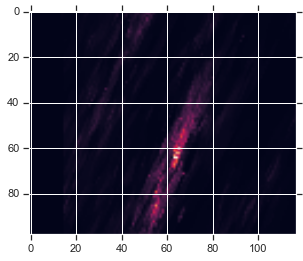

In [888]:
# Here is the day image
plt.imshow(daata[0])
plt.show()

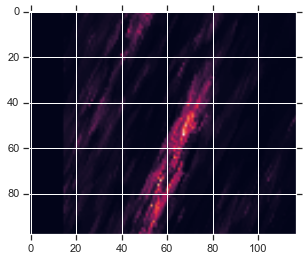

In [889]:
# Here is the night image
plt.imshow(daata[1])
plt.show()

In [901]:
names=['stationId', 'date', 'temp']

milanoTemperature = gl.SFrame(pd.read_csv('./Milano_WeatherPhenomena/mi_meteo_5897.csv', names=names).fillna(0))

In [902]:
names=['stationId', 'date', 'co']

milanoCO = gl.SFrame(pd.read_csv('./pollution-mi/mi_pollution_5823.csv', names=names).fillna(0))

In [905]:
joinedData = milanoCO.join(milanoTemperature, on='date').sort('date')

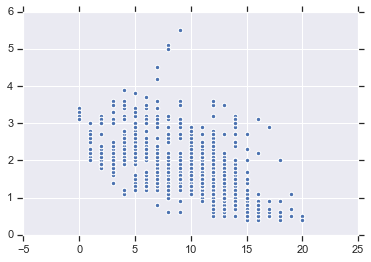

In [909]:
plt.scatter(joinedData['temp'], joinedData['co'])
plt.show()

In [915]:
names=['stationId', 'date', 'speed']

milanoWind = gl.SFrame(pd.read_csv('./Milano_WeatherPhenomena/mi_meteo_14391.csv', names=names).fillna(0))

In [916]:
joinedData2 = milanoCO.join(milanoWind, on='date').sort('date')

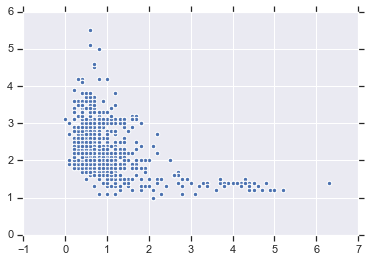

In [917]:
plt.scatter(joinedData2['speed'], joinedData2['co'])
plt.show()